# SentifyMaster: sentiment analysis using twitters api

# Building the Analyzer

In [1]:
# Importing  necessary libraries

from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
from collections import Counter

import string
import nltk
import spacy

import matplotlib.pyplot as plt
import seaborn as sns


import pandas as pd 
pd.set_option('display.max_colwidth', None)



nlp = spacy.load("en_core_web_sm")  # download the english model
nltk.download('stopwords')          # download common stopwords from nltk

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nabilyimer/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
class SentimentAnalyzer():
    
    def __init__(self):
        self.vectorizer = CountVectorizer(ngram_range=(1,3))
        
        self.model = SVC(kernel='linear')
        
        self.smote = SMOTE(random_state = 42 ,sampling_strategy='minority')

        
    def pre_process(self,text):
        tokens = nlp(text)
        
        # lemmatize

        tokens = [token.lemma_ for token in tokens]

        # remove stopwords and punctuations
                                                                                       # including targeted person and negation   
        stopwords_ = [word for word in nltk.corpus.stopwords.words('english') if word not in ['he', 'she','no', 'not', 'they', 'you']]

        tokens = [token for token in tokens if not token in string.punctuation and not token in stopwords_]                                            

        return ' '.join(tokens)



    def train(self,X_train,y_train):
        
        # vectorizing preprocessed text
        
        train = [self.pre_process(txt) for txt in X_train]
        
        train_vector = self.vectorizer.fit_transform(train)
        
        # handling the imbalanced labels
        X_train_smote,y_train_smote = self.smote.fit_resample(train_vector.astype('float'),y_train)

        # fitting the SVM
        self.model.fit(X_train_smote,y_train_smote)
        


    def predict(self,X_test):
        
        # pre-process by itrating over the df or if it is a single tweet 
        test = [self.pre_process(txt) for txt in X_test] if not isinstance(X_test,str) else [self.pre_process(X_test)]
        test_vector = self.vectorizer.transform(test)
        
        yhat_test = self.model.predict(test_vector)
        
        return yhat_test
    

In [11]:
train = pd.read_csv('sentiments.csv')[:200_000]
X_train_0 = train['text']
y_train_0 = train['label']

label = { 
    
    0 :'sadness'   ,
    1 :'joy'       ,
    2 : 'love'     ,
    3 : 'anger'    ,
    4 :  'fear'    ,
    5 : 'surprise'
    
        }



In [21]:
Counter(y_train_0)  # checking the imbalance

Counter({1: 67484, 0: 58543, 3: 27443, 4: 22859, 2: 16410, 5: 7261})

In [13]:
# spliting the data into train and validation

X_train,X_val,y_train,y_val = train_test_split(X_train_0,y_train_0,test_size=0.2,random_state=42)

In [14]:
# creating an object 
model = SentimentAnalyzer()

# runing the train function which pre-processes the text then fits to the model
model.train(X_train,y_train)

# doing inference
yhat_val = model.predict(X_val)


In [15]:
# organizing the result
results = pd.DataFrame({'Tweet':X_val,'Sentiment': yhat_val}) 

results['Sentiment'].replace(label,inplace=True)

results.head(5)

,Tweet,Sentiment
119737,i went to my weekly grief counseling session and i was feeling extremely emotional and unstable somehow,sadness
72272,i feel a cold coming on becky what is that recipe for the feel better smoothie,anger
158154,i think even those who have the passion and intelligence to appreciate feel and especially write poetry have sort of resigned themselves to the fact that poetry hasnt really sold well since neruda or earlier,sadness
65426,i feel like the time ive devoted to kroger and school would have been much more productively put to use elsewhere,love
30074,i weigh about but that still doesn t make me feel any better about that when i used to weigh,joy


### Evaluating the Results

In [76]:
scores = pd.DataFrame(classification_report(yhat_val,y_val,zero_division=1,output_dict=True))
scores = scores.iloc[0:3,0:6]
scores.columns = label.values()
scores

,sadness,joy,love,anger,fear,surprise
precision,0.934014,0.914030,0.710057,0.886360,0.811333,0.788018
recall,0.934903,0.908590,0.740472,0.890029,0.842215,0.675127
f1-score,0.934458,0.911302,0.724946,0.888190,0.826486,0.727217


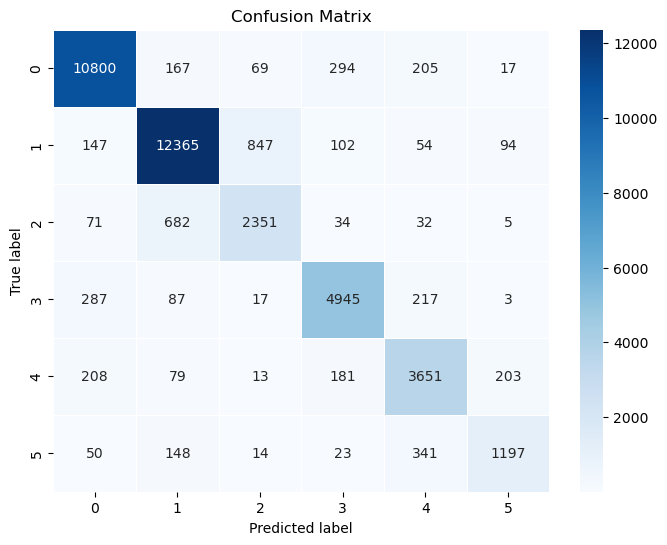

<Figure size 640x480 with 0 Axes>

In [20]:
conf_matrix = confusion_matrix(yhat_val,y_val)



# Plot the heatmap

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, cmap='Blues', annot=True, fmt='d', linewidths=.5)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

plt.savefig('confusion_matrix.png')


### Let's do some infrence on tweets

In [83]:

tweet_1 = (
    "Generative AI shows a stark contrast: exploration yields quality, "
    "but practical use disappoints. Hype versus reality leads to frustration."
)

yhat_1 = model.predict(tweet_1)




tweet_2 = "I couldn't believe my eyes when I saw the unexpected outcome of the experiment. i was overly shocked"



yhat_2 = model.predict(tweet_2)


tweet_3 = "Just received the best news ever! I'm over the moon with excitement!"

yhat_3 = model.predict(tweet_3)


print(tweet_1,'|',label[yhat_1[0]],'\n')

print(tweet_2,'|',label[yhat_2[0]],'\n')

print(tweet_3,'|',label[yhat_3[0]],'\n')





Generative AI shows a stark contrast: exploration yields quality, but practical use disappoints. Hype versus reality leads to frustration. | sadness 

I couldn't believe my eyes when I saw the unexpected outcome of the experiment. i was overly shocked | surprise 

Just received the best news ever! I'm over the moon with excitement! | joy 



### A Callenge i faced

In [19]:
# this shows that unhappyness is sadness
tweet = "I feel really unhappy."

yhat = model.predict(tweet)

print(tweet,"|",label[yhat[0]])

# what if we try not happiness ??

tweet_ = "I am not happy."

yhat = model.predict(tweet_)

print(tweet_,"|",label[yhat[0]])

I feel really unhappy. | sadness
I am not happy. | joy


tried to fix by increasing the Number of Bags to 2,3.. but no effect